In [3]:
from __future__ import print_function
import pandas as pd #For easier csv parsingFor easier csv parsing
import numpy as np 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import utils ,transforms
from data_classes import DataSetClass,ToTensor,Normalize
from models import Net_CNN,Net_CNN_LSTM,Net_CNN_LSTM2
import matplotlib.pyplot as plt
import cv2 
import time

In [4]:
# main path
DATA_PATH = "/home/anis/Desktop/Navigation/datasets/data/CSV/"
model_path = "/home/anis/Desktop/Navigation/End-To-End Target-Oriented Learning-Based Mobile Robot Naivgation/model_trainning/"

In [5]:
#data size
csv_train_cmd = pd.read_csv(DATA_PATH+"train/command_velocities.csv")
csv_valid_cmd = pd.read_csv(DATA_PATH+"valid/command_velocities.csv")
csv_eval_cmd = pd.read_csv(DATA_PATH+"eval/eval/command_velocities.csv")
print(csv_train_cmd.iloc[50])
print("trainning dataset  size: ",len(csv_train_cmd),"samples")
print("validation dataset  size: ",len(csv_valid_cmd),"samples")
print("evaluation dataset  size: ",len(csv_eval_cmd),"samples")


linearX     0.115789
angluarV   -0.066524
Name: 50, dtype: float64
trainning dataset  size:  225296 samples
validation dataset  size:  24889 samples
evaluation dataset  size:  9556 samples


## Data Distribution

In [ ]:
# goals distribution
csv_train_goal = pd.read_csv(DATA_PATH+"train/goals.csv")
goals = csv_train_goal.iloc[:,0:2]
li = []
goals = np.asarray(goals)
plt.scatter(goals[:,0],goals[:,1], s=0.01, marker='.', c='r')
plt.show()

In [ ]:
## velocity commands distribtution
# load angular velocities
angular_v = csv_valid_cmd.iloc[:,1]
angular_v = np.asarray(angular_v)#*180/np.pi

#load linear velocities 
linear_v = csv_valid_cmd.iloc[:,0]
linear_v = np.asarray(linear_v)


#create histogram
fig = plt.figure()
cmd_angular = plt.subplot(1,2,1)
cmd_linear = plt.subplot(1,2,2)
fig.suptitle('dataset velocities distribution')

cmd_angular.hist(angular_v,bins = 40)
cmd_angular.set_xlabel('angular [rad/s]')
cmd_angular.set_ylabel('instances')

cmd_linear.hist(linear_v,bins = 60)
cmd_linear.set_xlabel('linear [m/s]')
cmd_linear.set_ylabel('instances')

fig.savefig(model_path+"images/steering_distribution_data.jpg")
fig.show()

## Data Loader ##

### iteratre through the dataset ###

In [12]:
datasetTrain = DataSetClass(Data_Path=DATA_PATH+"train/",window_len=None,include_Vy=False,transform=transforms.Compose([ToTensor(),Normalize()]))
datasetValid = DataSetClass(Data_Path=DATA_PATH+"valid/",window_len=None,include_Vy=False,transform=transforms.Compose([ToTensor(),Normalize()]))

print("data_train_size",len(datasetTrain))
print("data_valid_size",len(datasetValid))

print("Train Samples")
for i in range(len(datasetTrain)):
    sample = datasetTrain[i]
    print("index",i,"\t scan size",sample["scan"].shape,"\t goal",sample["goal"],"\t steering",sample["steering"])

    if i==1:
        break
print("Valid Samples")
for i in range(len(datasetValid)):
    sample = datasetValid[i]
    print("index",i,"\t scan size",sample["scan"].shape,"\t goal",sample["goal"],"\t steering",sample["steering"])

    if i==1:
        break



data_train_size 225296
data_valid_size 24889
Train Samples
index 0 	 scan size torch.Size([1, 360]) 	 goal tensor([-2.5259,  1.5150,  0.0053], dtype=torch.float64) 	 steering tensor([-2.3033, -0.0066], dtype=torch.float64)
index 1 	 scan size torch.Size([1, 360]) 	 goal tensor([-2.5008,  1.5282, -1.8487], dtype=torch.float64) 	 steering tensor([-0.8382, -0.2242], dtype=torch.float64)
Valid Samples
index 0 	 scan size torch.Size([1, 360]) 	 goal tensor([-0.7682, -1.9910, -1.5669], dtype=torch.float64) 	 steering tensor([ 0.1874, -0.3974], dtype=torch.float64)
index 1 	 scan size torch.Size([1, 360]) 	 goal tensor([-0.7778, -2.0039, -1.5540], dtype=torch.float64) 	 steering tensor([ 0.1874, -0.3890], dtype=torch.float64)


### DataLoader ### 
allows,
Batching the data,
Shuffling the data,
Load the data in parallel using multiprocessing workers.

In [13]:
batch_size = 128
shuffle_dataset = False
num_workers = 4
trainloader = torch.utils.data.DataLoader(datasetTrain, batch_size=batch_size,shuffle=shuffle_dataset,
                                         num_workers=num_workers,drop_last=True)
validloader = torch.utils.data.DataLoader(datasetValid, batch_size=batch_size,shuffle=shuffle_dataset,
                                               num_workers=num_workers,drop_last=True)

### test DataLoader ###

In [ ]:
dataiter = iter(validloader)
sample  = dataiter.next()
scan,steering,goal = sample["scan"],sample["steering"],sample["goal"]

print(len(dataiter))
print("\n scan size",scan[0,0,:5],"\n goal",goal[0],"\n steering",steering[0])


## Learning Model ##

In [14]:
#initialize model
#model = Net_CNN()
model = Net_CNN_LSTM2(mode="train",bidirectional=False,sequence_length=8)

### parameter counter ###

In [15]:
# Number of parameters 
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(count_parameters(model))

10234178


## Load Model ##

In [6]:
#checkpoint
Model_path = model_path+"models/cnnlstm_model_test.pth"
if torch.cuda.is_available():
        checkpoint = torch.load(Model_path)
        model.load_state_dict(checkpoint["state_dict"])
        # lodading the optimizer to cuda
        #optimizer.load_state_dict(checkpoint["optimizer"])

        # for state in optimizer.state.values():
        #     for k, v in state.items():
        #         if isinstance(v, torch.Tensor):
        #             state[k] = v.cuda()

else:
    checkpoint = torch.load(Model_path, map_location=torch.device('cpu'))
    model.load_state_dict(checkpoint["state_dict"])

print("loss: ", checkpoint["valid_losses"][-1][0],"lr:", checkpoint["lr"][-1][0],"epoch: ",checkpoint["valid_losses"][-1][1])

loss:  0.5614643135882422 lr: 0.001 epoch:  20


In [13]:
torch.save(checkpoint,Model_path)

### test model ###

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device: ",device)
model.to(device)
#get some random training images
dataiter =  iter(trainloader)
samples = dataiter.next()
scan = samples['scan'].to(device=device, dtype=torch.float)
goals = samples['goal'].to(device=device, dtype=torch.float)
steering = samples['steering'].to(device=device, dtype=torch.float)


since = int(round(time.time()*1000))
model.eval()
output = model(scan,goals)
print(output.size())

time_elapsed = int(round(time.time()*1000)) - since
print ('training time elapsed {}ms'.format(time_elapsed))

device:  cuda:0
torch.Size([16, 2])
training time elapsed 21ms


In [21]:
from loss_functions import MSELoss
loss_func = MSELoss()
model.eval()
loss_valid = 0.0
loss_linear_valid = 0.0
loss_angular_valid = 0.0
with torch.no_grad():
    for samples in validloader:

        scan, goal, steering = samples["scan"].to(device, dtype=torch.float), samples["goal"].to(
            device, dtype=torch.float), samples["steering"].to(device, dtype=torch.float)

        if True:
            # shape (batch,sequence,input)
            mini_batch = int(goal.size()[0]/8)
            steering = steering.view(
                (mini_batch, 8, -1))
            steering = steering[:, -1, :]

        output = model(scan, goal)

        loss, linear_loss, angular_loss = loss_func(
            output, steering)

        loss_valid += loss.item()
        loss_linear_valid += linear_loss.item()
        loss_angular_valid += angular_loss.item()
print(np.sqrt(loss_valid/len(validloader)))

151.5459257438779


## Train Model ##

In [ ]:
#import Train packages
from loss_functions import MSELoss,MAELoss
from train import TrainClass

### optimizer ###

In [ ]:
optimizer = optim.Adam(model.parameters(),lr=0.000005)


### train ###

In [ ]:
Train = TrainClass(Net=model,optimizer=optimizer,trainloader=trainloader, validloader=validloader, criterion=MSELoss,
                 model_path=model_path+'models/cnnlstm_model', checkpoint_=checkpoint, batch_size=batch_size,sequence_length=8)

In [ ]:
Train.train(epochs=30,single_optimize=True)


 Training started from a checkpoint

 Training started at  Wed Nov 25 09:59:11 2020
Device  cuda:0
epoch:  1 Train_loss: 0.74746 Valid_loss: 0.65240 lr: 0.00010 [valid_linear: 0.47903, valid_angular:0.78853]
epoch:  2 Train_loss: 0.68539 Valid_loss: 0.60084 lr: 0.00010 [valid_linear: 0.47208, valid_angular:0.70651]
epoch:  3 Train_loss: 0.61322 Valid_loss: 0.54552 lr: 0.00010 [valid_linear: 0.47807, valid_angular:0.60550]
epoch:  4 Train_loss: 0.56199 Valid_loss: 0.50701 lr: 0.00010 [valid_linear: 0.46975, valid_angular:0.54171]
epoch:  5 Train_loss: 0.53632 Valid_loss: 0.48496 lr: 0.00010 [valid_linear: 0.46700, valid_angular:0.50228]
epoch:  6 Train_loss: 0.52013 Valid_loss: 0.47310 lr: 0.00010 [valid_linear: 0.46069, valid_angular:0.48518]
epoch:  7 Train_loss: 0.50972 Valid_loss: 0.47109 lr: 0.00010 [valid_linear: 0.46125, valid_angular:0.48073]
epoch:  8 Train_loss: 0.50043 Valid_loss: 0.46122 lr: 0.00010 [valid_linear: 0.45330, valid_angular:0.46900]
epoch:  9 Train_loss: 0.4923

KeyboardInterrupt: ignored

## Loss ##

epoch: 1 ,train 0.74746,valid 0.65240,[linear 0.47903, angular 0.78853]
epoch: 2 ,train 0.68539,valid 0.60084,[linear 0.47208, angular 0.70651]
epoch: 3 ,train 0.61322,valid 0.54552,[linear 0.47807, angular 0.60550]
epoch: 4 ,train 0.56199,valid 0.50701,[linear 0.46975, angular 0.54171]
epoch: 5 ,train 0.53632,valid 0.48496,[linear 0.46700, angular 0.50228]
epoch: 6 ,train 0.52013,valid 0.47310,[linear 0.46069, angular 0.48518]
epoch: 7 ,train 0.50972,valid 0.47109,[linear 0.46125, angular 0.48073]
epoch: 8 ,train 0.50043,valid 0.46122,[linear 0.45330, angular 0.46900]
epoch: 9 ,train 0.49238,valid 0.46130,[linear 0.45922, angular 0.46337]
epoch: 10 ,train 0.48563,valid 0.46043,[linear 0.45761, angular 0.46324]
epoch: 11 ,train 0.48013,valid 0.45989,[linear 0.45679, angular 0.46297]
epoch: 12 ,train 0.47417,valid 0.44831,[linear 0.45049, angular 0.44612]
epoch: 13 ,train 0.47029,valid 0.44872,[linear 0.44575, angular 0.45167]
epoch: 14 ,train 0.46476,valid 0.44784,[linear 0.44863, angu

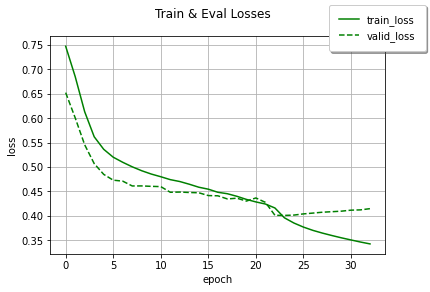

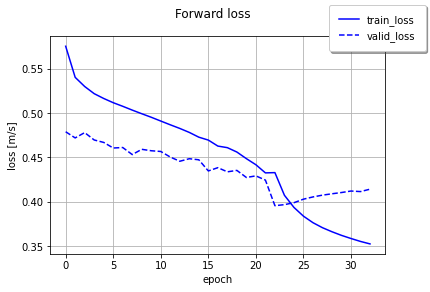

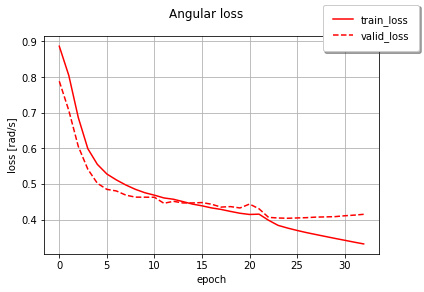

In [ ]:
train_losses = checkpoint["train_losses"]
train_linear = checkpoint["train_linear"]
train_angular = checkpoint["train_angular"]
valid_linear = checkpoint["valid_linear"]
valid_angular= checkpoint["valid_angular"]
valid_losses = checkpoint["valid_losses"]
start_epochs = checkpoint["epoch"]
losstl = []
lossta = []
lossvl = []
lossva = []
epoch  = []
loss_t = []
loss_v = []
for i in range(start_epochs):
  losstl.append(train_linear[i][0])
  lossta.append(train_angular[i][0])
  lossvl.append(valid_linear[i][0])
  lossva.append(valid_angular[i][0])
  loss_t.append(train_losses[i][0])
  loss_v.append(valid_losses[i][0])  
  print("epoch: %d ,train %.5f,valid %.5f,[linear %.5f, angular %.5f]"%(i+1,train_losses[i][0],valid_losses[i][0],valid_linear[i][0],valid_angular[i][0]))
  epoch.append(i)


#plot  losses
trainFig, lossall = plt.subplots()
trainFig.suptitle('Train & Eval Losses')

lossall.plot(epoch,loss_t,'g',label="train_loss")
lossall.plot(epoch,loss_v,'g--',label="valid_loss")
lossall.set_ylabel('loss')
lossall.set_xlabel('epoch')
plt.grid(True)

trainFig.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)
trainFig.savefig(model_path+"images/loss_lstmcnn.png")

forwardFig, linear = plt.subplots()
forwardFig.suptitle('Forward loss')
linear.plot(epoch,losstl,'b',label="train_loss")
linear.plot(epoch,lossvl,'b--',label="valid_loss")
linear.set_ylabel('loss [m/s]')
linear.set_xlabel('epoch')
plt.grid(True)

forwardFig.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)
forwardFig.savefig(model_path+"images/linear_loss_lstmcnn.png")


angularFig, angular = plt.subplots()
angularFig.suptitle('Angular loss')
angular.plot(epoch,lossta,'r',label="train_loss")
angular.plot(epoch,lossva,'r--',label="valid_loss")
angular.set_ylabel('loss [rad/s]')
angular.set_xlabel('epoch')
plt.grid(True)
angularFig.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)
angularFig.savefig(model_path+"images/angular_loss_lstmcnn.png")
plt.show()


In [4]:
### load trained model ###
Model_path = model_path+'models/cnnlstm_model_test.pth'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Net_CNN_LSTM(mode="eval")
model.to(device)

checkpoint = torch.load(Model_path,map_location=torch.device(device))
model.load_state_dict(checkpoint["state_dict"])
#model.eval()

<All keys matched successfully>

## Evaluation ##

In [5]:
#load the evaluation datasets
evalDataEval = DataSetClass(Data_Path=DATA_PATH+"eval/eval/",include_Vy=True,transform=transforms.Compose([ToTensor(),Normalize()]))

batch_size = 1
shuffle_dataset = False
num_workers = 8

evalDataLoader = torch.utils.data.DataLoader(evalDataEval, batch_size=batch_size,shuffle=shuffle_dataset,
                                               num_workers=num_workers,drop_last=True)
                                               

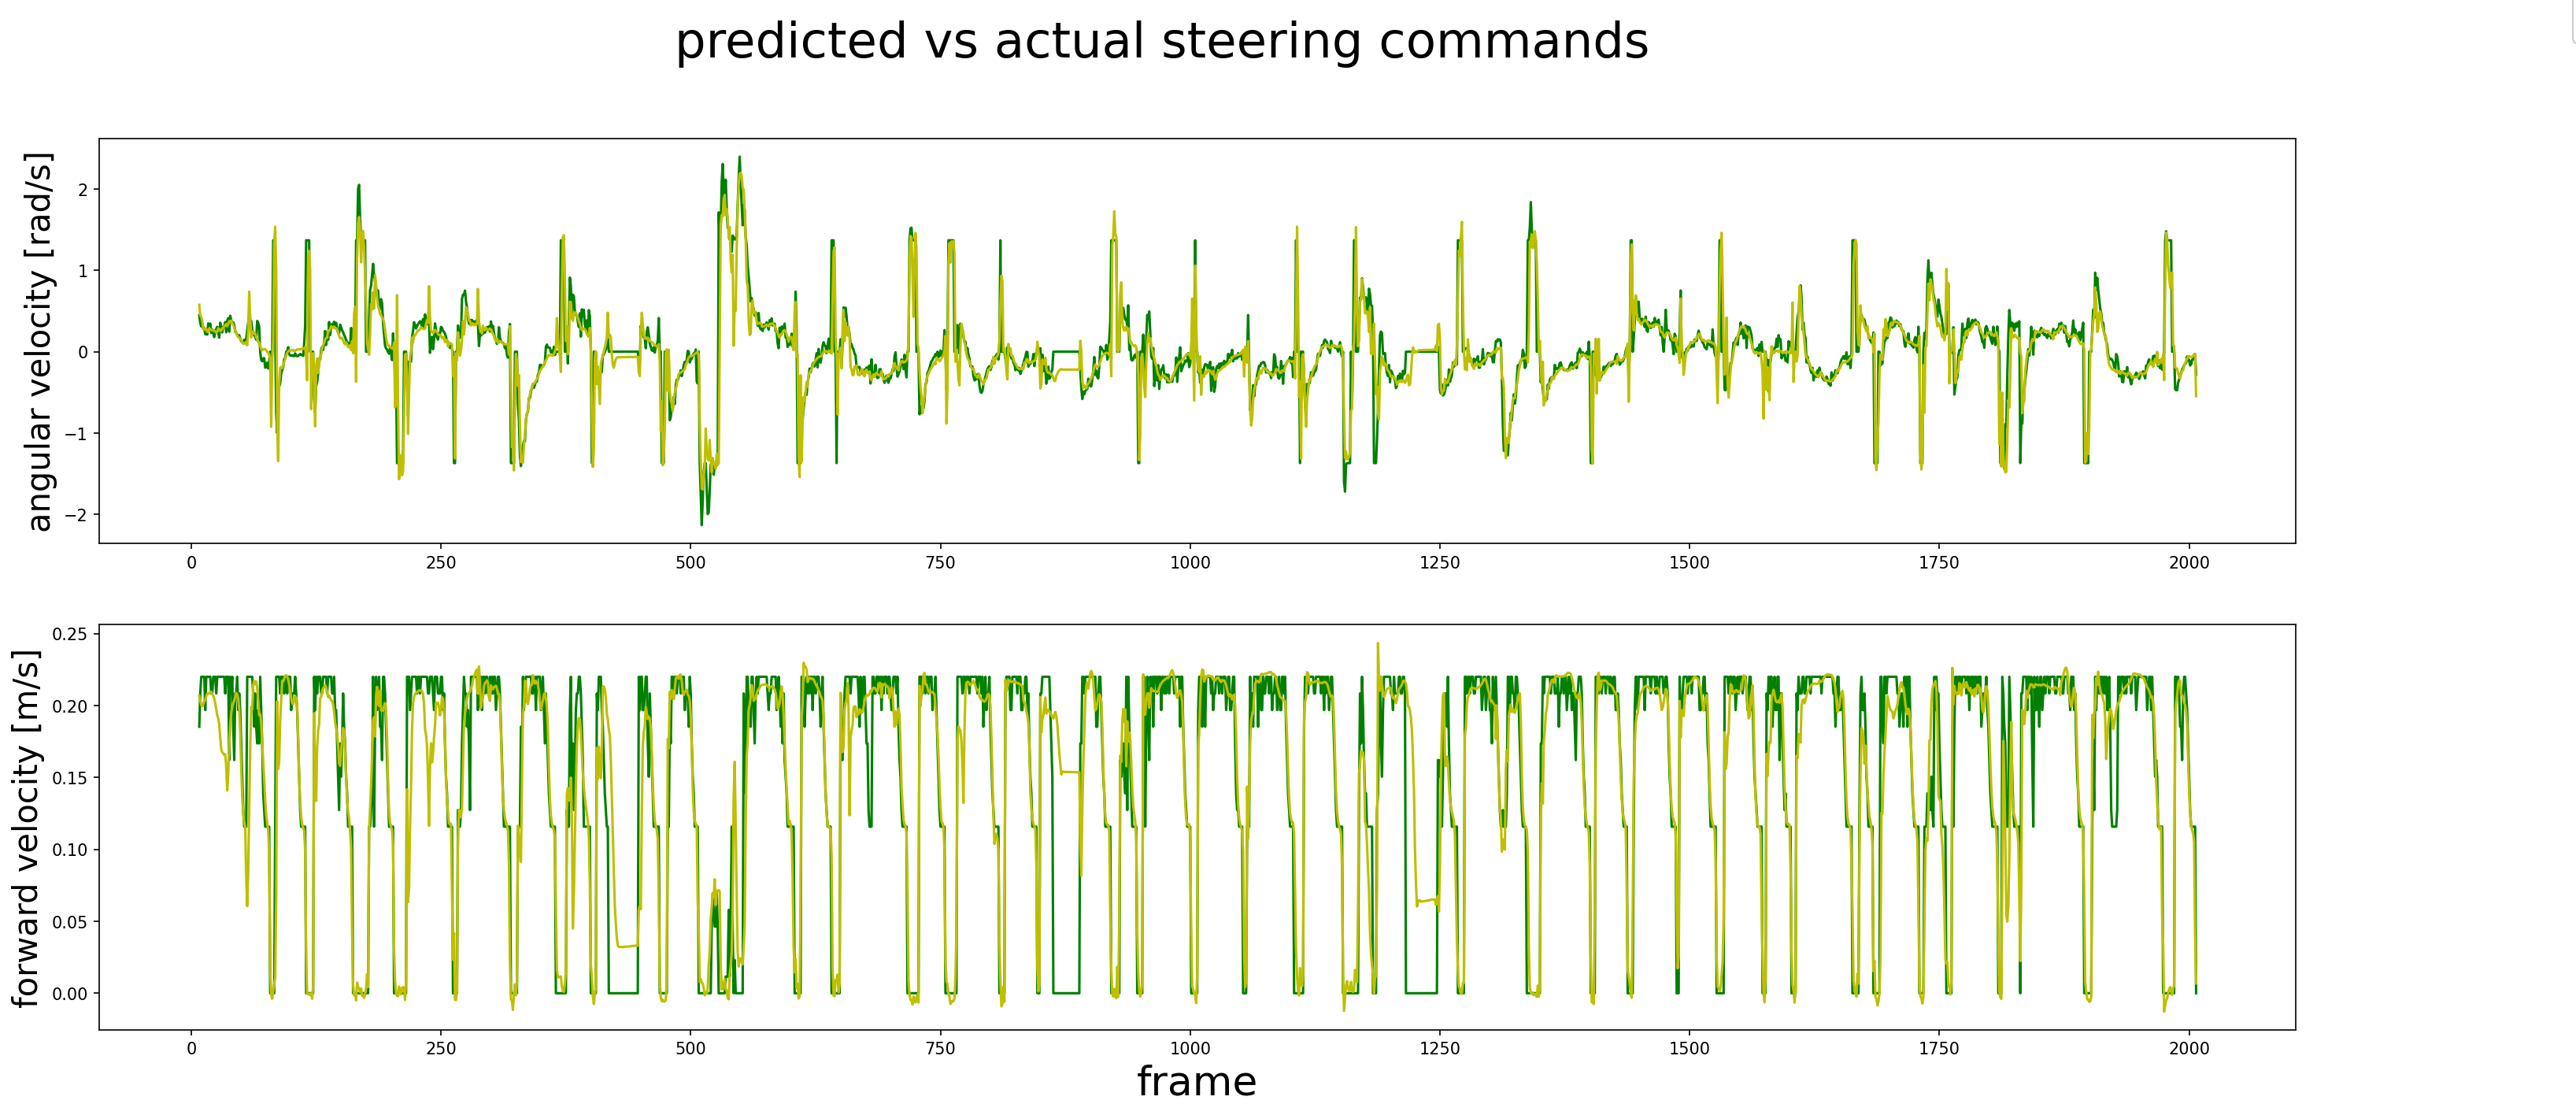

In [ ]:
#ploat predicted and actual velocities
from eval import plotVelocities
plotVelocities(evalDataLoader,device,model,root_dir=model_path,model_arch="lstmcnn")

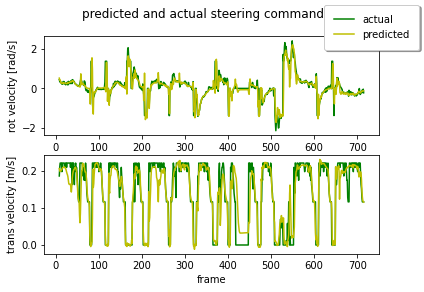

In [ ]:
#ploat predicted and actual velocities
from eval import plotVelocities
plotVelocities(evalDataLoader,device,model,root_dir=model_path,model_arch="lstmcnn")